In [3]:
# Import necessary packages
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election, grid)
from gerrychain.metrics import mean_median, partisan_bias, polsby_popper, efficiency_gap
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import inspect
import pickle
import geopandas as gp
from shapely.geometry import LineString, Polygon
from shapely.ops import unary_union
import itertools

In [4]:
# Import tools file
from gerrymandering_tools import *

In [55]:
precincts = gp.read_file("../../../new_shp.shp")

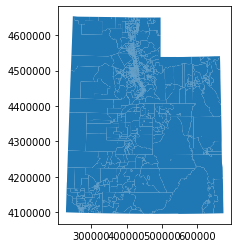

In [69]:
precincts.plot()

In [56]:
# Get the graph data
utah = Graph.from_json("../../../graph.json")

In [57]:
# Through observation, I have determined that the following small changes should be made

# Delete a very small polygon from the geometry of precinct 175 because it makes district 3 disconnected.
precincts.loc[175, 'geometry'] = precincts.loc[175]['geometry'][0]

precincts.loc[101,'geometry'] = precincts.loc[101]['geometry'][0]

precincts.loc[453,'geometry'].buffer(20)
# Put precinct 1887 (population zero) into district 0.
# (I believe this is an error because several online sources list that all of Summit County is in district 0.)
utah.nodes[1887]['US_Distric'] = 0
precincts.loc[1887, 'US_Distric'] = 0

TypeError: 'Polygon' object is not subscriptable

In [74]:
utah.nodes[1887]['US_Distric'] = 0
precincts.loc[1887, 'US_Distric'] = 0

The goal of this jupyter notebook is to demonstate three types of algorithmic precinct merging, which resolve the following three problems: 1) Zero-Population Precincts, 2) Discontiguities in Precinct Geometries, 3) Precincts Contained within Other Precincts. These must be done in this order. The reasoning for the ordering is as follows. Once zero-population precincts are merged with their neighbors they no longer have zero population, and no amount of merging will bring the population back down to zero. Therefore, changes will not be reverted by future merges. However, merging precincts may close off other precincts and result in more of problem 3. Therefore, this step must be performed last. 

# Section 1: Merging Zero-Population Precincts

In the precinct data there are 341 precincts that have zero population. The presence of these presence does not affect the vote shares or political data of the congressional districts, but it does affect their geometry. In particular, switching the district assignment for a zero-population precinct may change the Polsby-Popper score or the number of cut edges, while not changing the district assignment for any voters. Therefore if we allow zero-population precincts, it is possible for equivalent plans to have different cut-edge or Polsby-Popper scores. One way to resolve this issue is to merge zero-population precincts with their neighbors. This method has the additional advantage that it reduces the total number of precincts. Ceterus paribus, this means that the Markov chain generated by flipping precincts will take fewer steps to explore the sample place and to mix. 

The only question remaining is: which neighbor should a zero-population precinct node be merged with? In some sense, this does not matter, becuase the resulting merged precinct will have the same population and partisan composition in any case. Therefore, any choice would be reasonable and would not affect the accuracy of the results. The process I use below to select which neighbor should be merged is to find all adjacent precincts which are in the same county and district (under the 2010 map), and then select the one with the largest shared perimeter. Other choices are possible, but as obvserved above, they will only lead to different geometry. 

In [77]:
# Choose the graph and gdf we are working with
graph, gdf = utah, precincts

In [45]:
s = np.nonzero(precincts['POP100'].isnull().values)

In [46]:
for i in s[0]:
    precincts.iloc[i, precincts.columns.get_loc('POP100')] = 0

In [47]:
precincts

index  CountyID    VistaID PrecinctID SubPrecinc VersionNbr  \
0        0.0        13       AL:A         AL          A       None   
1        1.0        13       AL:B         AL          B       None   
2        2.0        13         BU         BU       None       None   
3        3.0        13         BW         BW       None       None   
4        4.0        13         CM         CM       None       None   
...      ...       ...        ...        ...        ...        ...   
2969  2969.0        18  SLC002:00     SLC002         00       None   
2970  2970.0        18  PCN001:01     PCN001         01       None   
2971  2971.0        18  GSL001:00     GSL001         00       None   
2972  2972.0         3    MIL17:U      MIL17          U          5   
2973  2973.0         3    MIL17:U      MIL17          U          5   

      EffectiveD       AliasName Comments    RcvdDate  ...  BLKGRP  AIANHH  \
0     2012-01-01            None  kanerds  2012-02-02  ...       1    9999   
1     2012-01-01            None  kanerds  2012-02-02  ...       1    9999   
2     2012-01-01            None  kanerds  2012-02-02  ...       1    9999   
3     2012-01-01            None  kanerds  2012-02-02  ...       2    9999   
4     2012-01-01            None  kanerds  2012-02-02  ...       1    9999   
...          ...             ...      ...         ...  ...     ...     ...   
2969  2018-08-31  Salt Lake City     None  2018-08-31  ...       2    9999   
2970  2018-08-31  Unincorporated     None  2018-08-31  ...       2    9999   
2971  2018-08-31  Unincorporated     None  2018-08-31  ...       1    9999   
2972  2012-01-01       Millville     None  2018-09-13  ...    None    None   
2973  2012-01-01       Millville     None  2018-09-13  ...    None    None   

       AITS  AIANHHCC  TTRACT  TBLKGRP   CBSA  SDUNI       UrbanRural  \
0     99999        99  999999        9  99999  00480            Rural   
1     99999        99  999999        9  99999  00480            Rural   
2     99999        99  999999        9  99999  00480            Rural   
3     99999        99  999999        9  99999  00480            Rural   
4     99999        99  999999        9  99999  00480            Rural   
...     ...       ...     ...      ...    ...    ...              ...   
2969  99999        99  999999        9  41620  00870  Urbanized Areas   
2970  99999        99  999999        9  41620  00360            Rural   
2971  99999        99  999999        9  41620  00360            Rural   
2972   None      None    None     None   None   None             None   
2973   None      None    None     None   None   None             None   

                                               geometry  
0     POLYGON ((368501.080 4145343.340, 368496.430 4...  
1     POLYGON ((370858.860 4156086.710, 370972.660 4...  
2     POLYGON ((442101.710 4105063.140, 442102.510 4...  
3     POLYGON ((442101.710 4105063.140, 442088.160 4...  
4     POLYGON ((333462.020 4156801.320, 333518.150 4...  
...                                                 ...  
2969  POLYGON ((419212.160 4521470.590, 419214.020 4...  
2970  POLYGON ((443946.710 4520092.640, 443987.130 4...  
2971  MULTIPOLYGON (((420203.460 4519403.320, 420387...  
2972  POLYGON ((432287.390 4613800.590, 432169.480 4...  
2973  POLYGON ((431942.080 4613857.120, 431944.300 4...  

[2974 rows x 35 columns]

In [59]:
precincts['POP100'].isnull().values.any()

False

In [66]:
# Get all the zero-population precincts
zeros = np.array([1 if graph.nodes[n]['POP100'] == 0 else 0 for n in range(len(graph)) ])
zeros_list = [n for n in range(len(graph)) if graph.nodes[n]['POP100'] == 0 ]
print(np.count_nonzero(zeros))

341


(206340.0469999997, 696211.4729999999, 4066802.5100000007, 4681513.089999999)

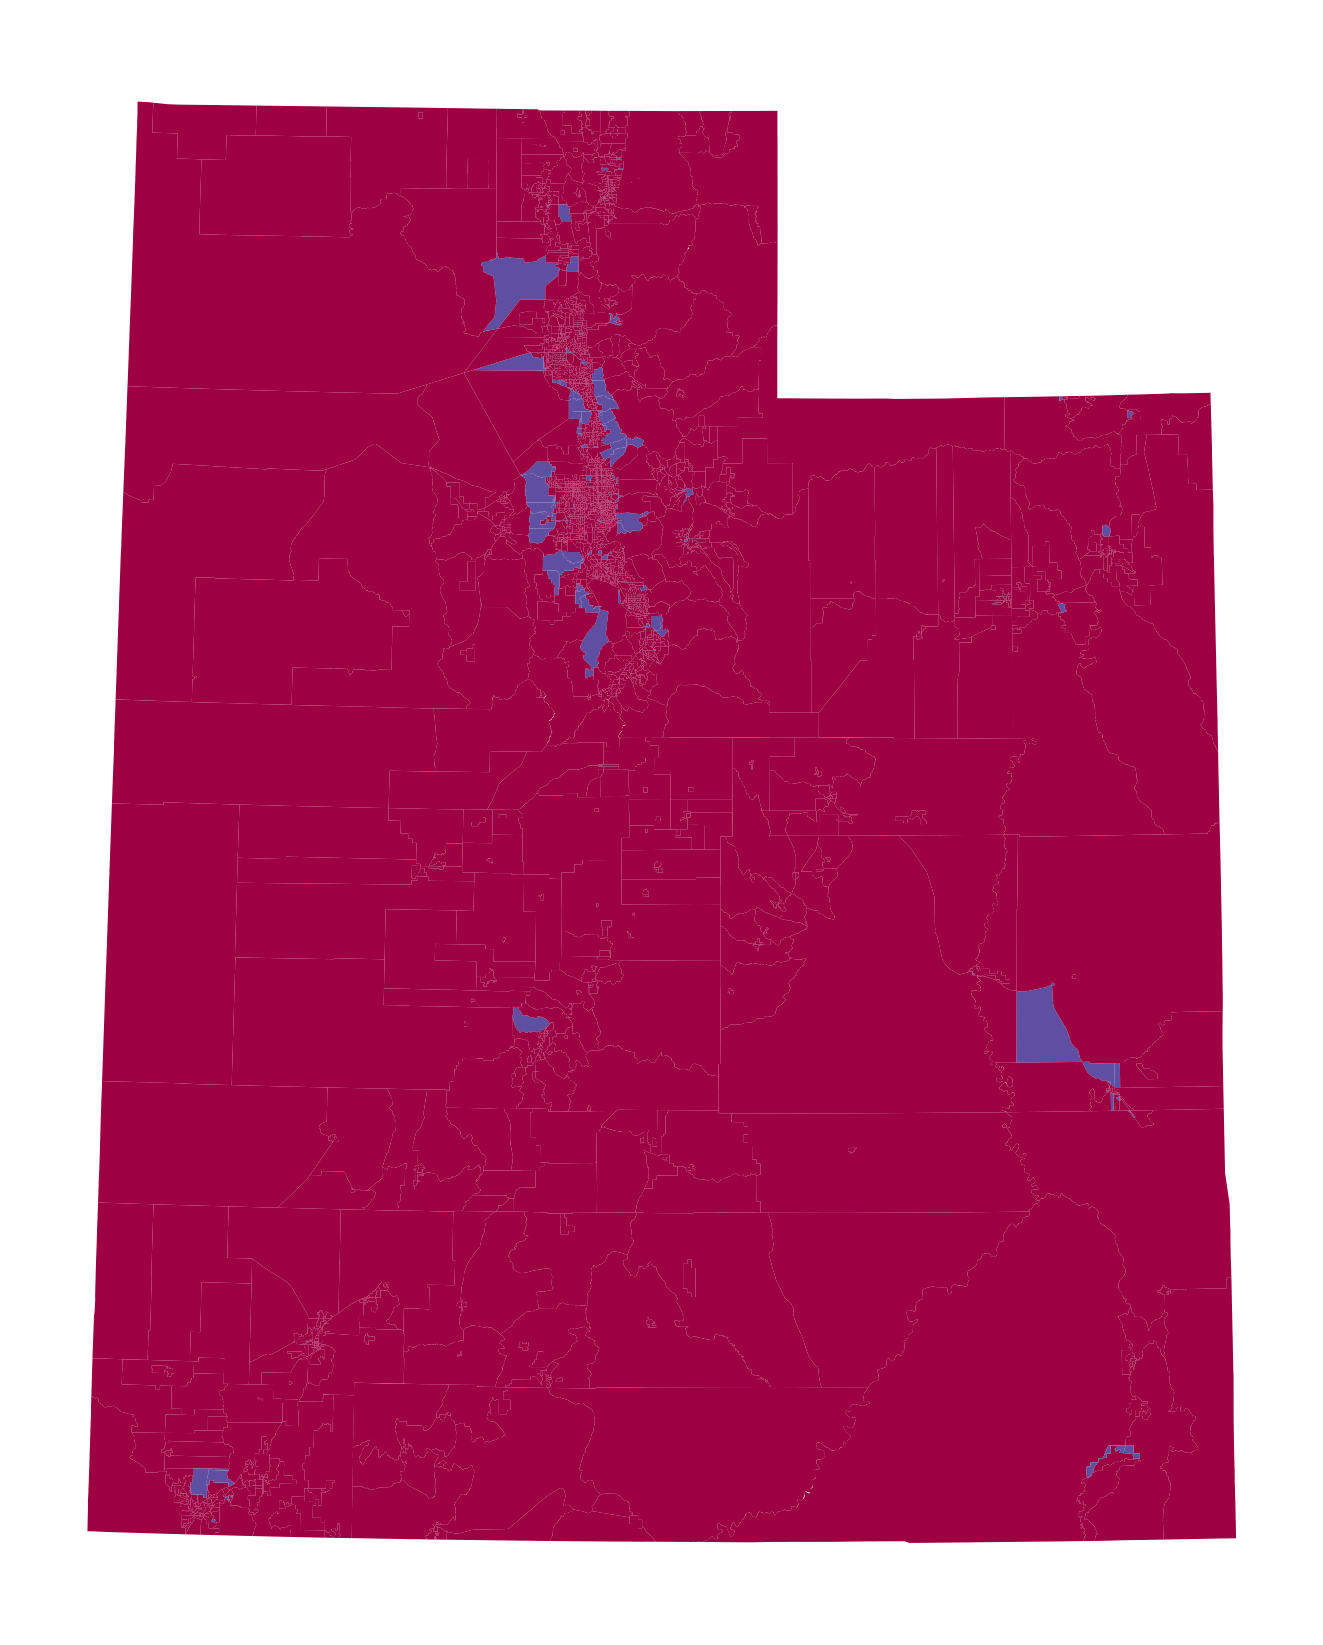

In [67]:
# Mark the zero-population nodes
f = gdf.copy()
f['zero_pop'] = zeros

# Plot the zero-population nodes
size, dpi =(14,7), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
f.plot(column='zero_pop', ax=ax, cmap='Spectral')
plt.axis("off")

# Legend: Red: Pop > 0, Blue: Pop = 0

In [76]:
for node in graph.nodes:
    if graph.nodes[node]['POP100'] == 0:
        neighbors = [n for n in graph[node].keys()
                           if graph.nodes[n]['CountyID'] == graph.nodes[node]['CountyID']
                           and graph.nodes[n]['US_Distric'] == graph.nodes[node]['US_Distric']
                           and graph.nodes[n]['POP100'] == 0]

        if len(neighbors) == 0:
            # Try using zero-population neighbors
            neighbors = [n for n in graph[node].keys()
                        if graph.nodes[n]['CountyID'] == graph.nodes[node]['CountyID']
                        and graph.nodes[n]['US_Distric'] == graph.nodes[node]['US_Distric']]
        print(node, neighbors)

38 [54, 60]
105 [96, 104]
125 [106, 128]
153 [113, 127, 146]
155 [111, 127, 142]
249 [239, 251, 269, 266]
250 [261]
257 [255, 256, 275, 277, 260, 258, 259, 262]
261 [250]
283 [323, 331, 307, 318]
347 [356, 348]
350 [345, 354]
386 [388, 393, 387, 392]
458 [437, 443, 450]
508 [557, 574, 585]
509 [516]
510 [554]
511 [636]
512 [574, 636]
514 [551, 552]
516 [509]
517 [541]
525 [636]
541 [517]
546 [636, 597, 571, 601]
602 [570, 591, 614, 633, 604, 615, 636]
669 [660, 661, 668]
674 [565, 611]
702 [686, 704, 738]
703 [704, 738]
706 [705, 719]
707 [677, 738]
708 [711, 719]
709 [711, 719]
710 [711, 719]
712 [711, 719]
713 [711, 719]
716 [689]
717 [689, 726]
718 [689, 734]
724 [723, 728, 725, 726]
730 [685, 729]
799 [741, 801, 823]
800 [846]
815 [741, 801]
829 [754, 826]
846 [800]
858 [887]
859 [882, 874]
860 [868]
861 [887, 865, 888]
862 [865, 888]
863 [875, 887]
864 [898]
866 [868]
867 [899, 873]
868 [860, 866]
869 [900, 881]
876 [898, 903]
877 [897]
880 [883]
881 [869]
883 [880]
891 [885, 890,

In [72]:
for node in graph.nodes:
    if graph.nodes[node]['POP100'] == 0:
        neighbors = [n for n in graph[node].keys()
                           if graph.nodes[n]['CountyID'] == graph.nodes[node]['CountyID']
                           and graph.nodes[n]['US_Distric'] == graph.nodes[node]['US_Distric']
                           and graph.nodes[n]['POP100'] == 0]

        if len(neighbors) == 0:
            # Try using zero-population neighbors
            neighbors = [n for n in graph[node].keys()
                        if graph.nodes[n]['CountyID'] == graph.nodes[node]['CountyID']
                        and graph.nodes[n]['US_Distric'] == graph.nodes[node]['US_Distric']]
        print(node, neighbors)
        best = neighbors[np.argmax([graph[node][n]['shared_perim'] for n in neighbors])]
                         
                         
            

38 [54, 60]
105 [96, 104]
125 [106, 128]
153 [113, 127, 146]
155 [111, 127, 142]
249 [239, 251, 269, 266]
250 [261]
257 [255, 256, 275, 277, 260, 258, 259, 262]
261 [250]
283 [323, 331, 307, 318]
347 [356, 348]
350 [345, 354]
386 [388, 393, 387, 392]
458 [437, 443, 450]
508 [557, 574, 585]
509 [516]
510 [554]
511 [636]
512 [574, 636]
514 [551, 552]
516 [509]
517 [541]
525 [636]
541 [517]
546 [636, 597, 571, 601]
602 [570, 591, 614, 633, 604, 615, 636]
669 [660, 661, 668]
674 [565, 611]
702 [686, 704, 738]
703 [704, 738]
706 [705, 719]
707 [677, 738]
708 [711, 719]
709 [711, 719]
710 [711, 719]
712 [711, 719]
713 [711, 719]
716 [689]
717 [689, 726]
718 [689, 734]
724 [723, 728, 725, 726]
730 [685, 729]
799 [741, 801, 823]
800 [846]
815 [741, 801]
829 [754, 826]
846 [800]
858 [887]
859 [882, 874]
860 [868]
861 [887, 865, 888]
862 [865, 888]
863 [875, 887]
864 [898]
866 [868]
867 [899, 873]
868 [860, 866]
869 [900, 881]
876 [898, 903]
877 [897]
880 [883]
881 [869]
883 [880]
891 [885, 890,

ValueError: attempt to get argmax of an empty sequence

In [68]:
# Get the merge
merge_zp = merge_zero_population(utah, precincts)

ValueError: attempt to get argmax of an empty sequence

(206340.0469999997, 696211.4729999999, 4066802.5100000007, 4681513.089999999)

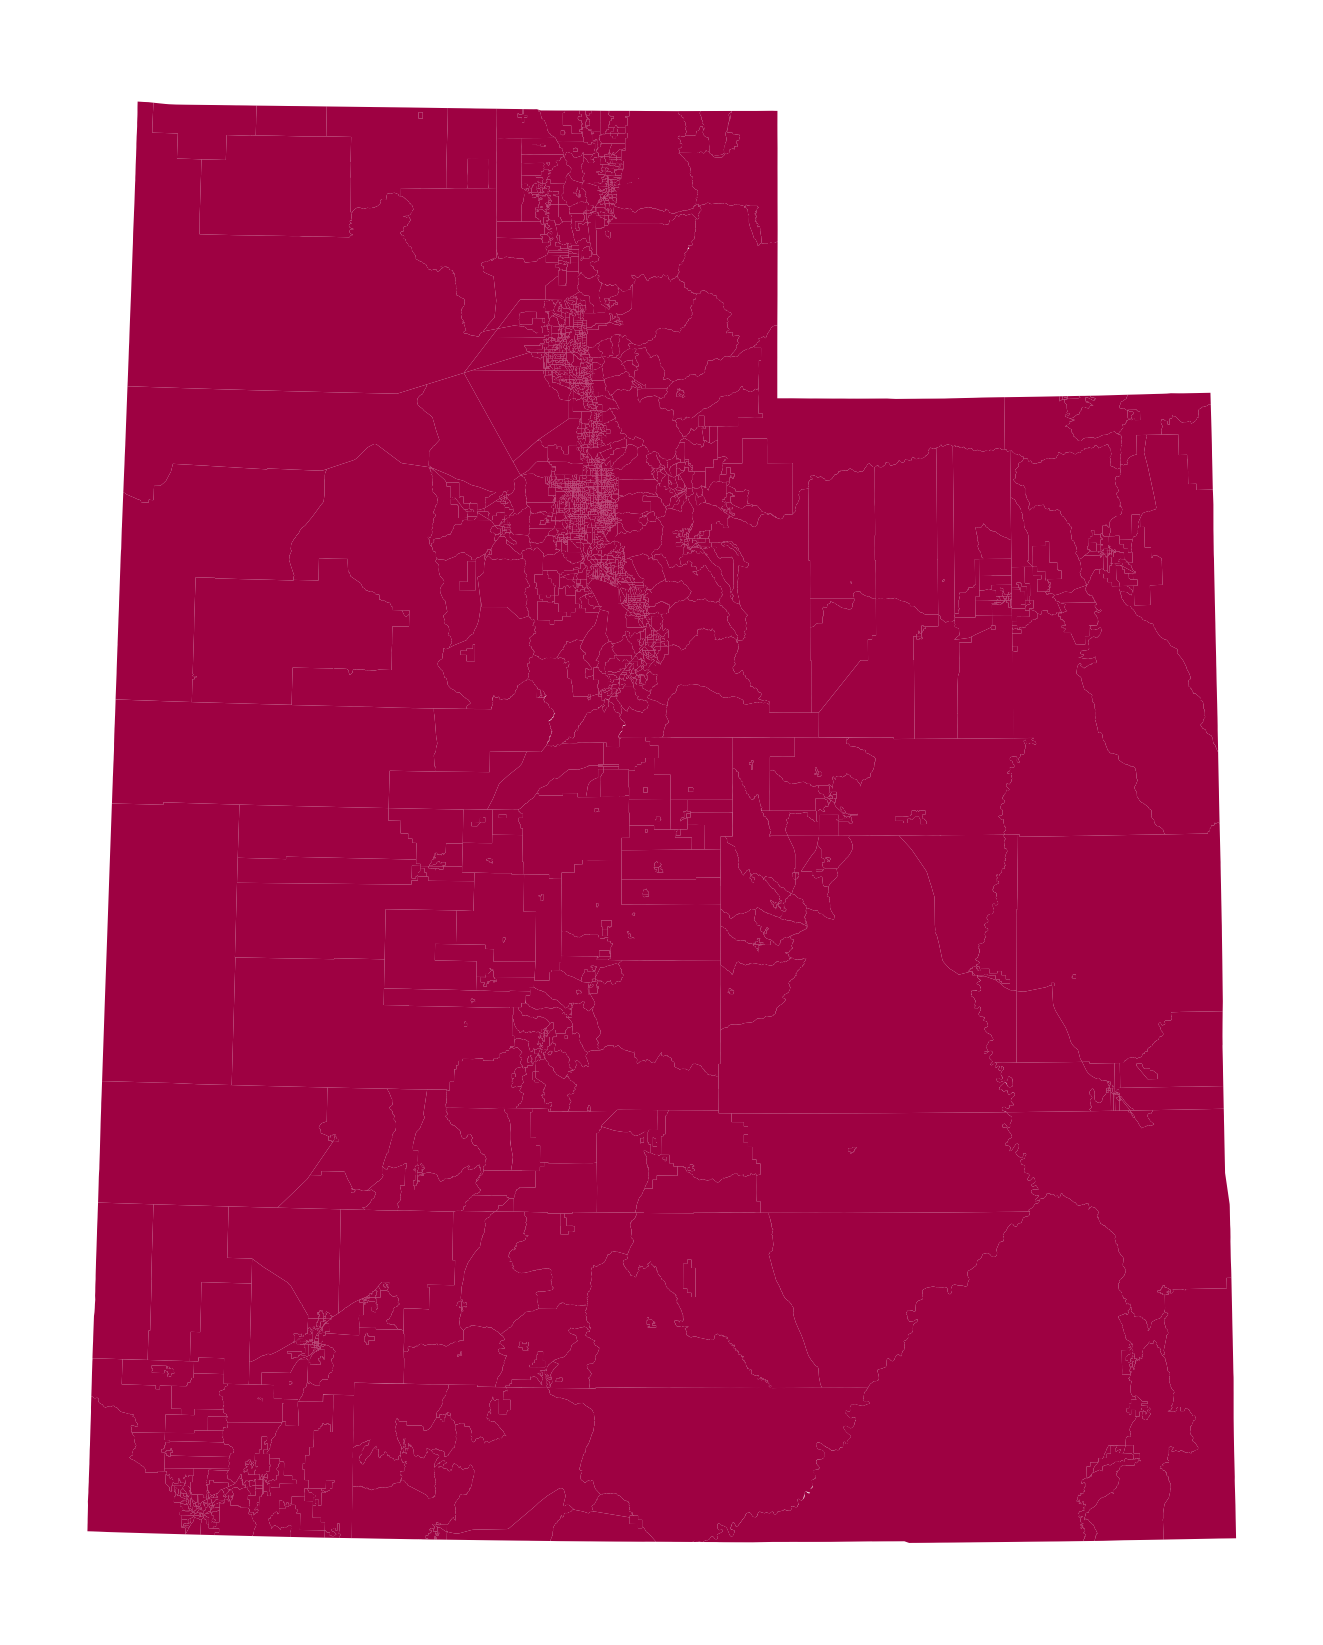

In [41]:
# Get the zero-population precincts along with the nodes they will be merged with
s = set([subpart for part in merge_zp.merges for subpart in part])
zeros_and_neighbors = np.array([1 if (n in s) else 0 for n in range(len(precincts)) ])

# Mark the zero-population nodes
f = gdf.copy()
f['zero_pop'] = 0.5*(zeros + zeros_and_neighbors)

# Plot the zero-population nodes
size, dpi = (14,7), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
f.plot(column='zero_pop', ax=ax, cmap='Spectral')
plt.axis("off")

# Legend: Red: Pop > 0, Blue: Pop = 0, Yellow: Neighboring precinct selected to be merged 

We have to perform the process iteratively, because some nodes may not have positive-population neighbors in the same congressional distrct and the same county. However, it turns out that we only need three iterations, and the result decreases the total number of precincts by exactly 341. 

In [10]:
# Perform the merge
graph = utah.copy()
gdf = precincts.copy()

iterations = 0
dissolves = []
merges = []
while sum( 1 for n in range(len(graph)) if graph.nodes[n]['POP100'] == 0 ) > 0:
    
    # get the merge and dissolve
    merge_zp = merge_zero_population(graph, gdf)
    dissolve_zp = merge_zp.get_dissolve()
    
    merges.append(merge_zp)
    dissolves.append(dissolve_zp)
    
    # perform the merge
    gdf = perform_dissolve_gdf(gdf, dissolve_zp,['geometry', ('CountyID', 'first'), ('VistaID', 'sum'), ('POP100', 'sum'), ('SEN_DEM', 'sum'), ('SEN_REP', 'sum'), ('G_DEM', 'sum'), ('G_REP', 'sum'),('US_Distric', 'first')],
                        new_column_names = ['geometry', 'CountyID', 'VistaID', 'POP100', 'DEM', 'REP', 'US_Distric']))
    graph = perform_dissolve_graph(graph, dissolve_zp,['area', 'SHAPE_Area', 'SEN_DEM', 'SEN_REP', 'G_DEM', 'G_REP', 'POP100'])
    print(gdf.columns)
    
    iterations += 1

gdf_zp = gdf
graph_zp = graph
print('Iterations: {}'.format(iterations))

C:\Users\Jacob\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


Index(['geometry', 'CountyID', 'VistaID', 'RcvdDate', 'POP100', 'DEM', 'REP',
       'US_Distric', 'UT_STATE', 'UT_HOUSE'],
      dtype='object')


C:\Users\Jacob\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


Index(['geometry', 'CountyID', 'VistaID', 'RcvdDate', 'POP100', 'DEM', 'REP',
       'US_Distric', 'UT_STATE', 'UT_HOUSE'],
      dtype='object')
Index(['geometry', 'CountyID', 'VistaID', 'RcvdDate', 'POP100', 'DEM', 'REP',
       'US_Distric', 'UT_STATE', 'UT_HOUSE'],
      dtype='object')
Iterations: 3


C:\Users\Jacob\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


The merge and dissolve objects are important because they document which precincts we merged. We can compose merges by using __mul__, and we can compose dissolves by slicing. This way we can remember which old precincts correspond to which new precincts. Technically, this information will also be recorded in the precinct metadata. The way I have written the code, the VistaID of a merged precinct is a concatenation of the VistaIDs of its constituents.

In [11]:
# Get the merge that summarizes all of the above information
merge_zp = merges[0] * merges[1] * merges[2]
dissolve_zp = merge_zp.get_dissolve(len(utah))

In [12]:
# Check that the code works right
all(merge_zp.get_dissolve() == dissolves[2][dissolves[1][dissolves[0]]])

True

In [13]:
# Check to make sure none of the new precincts have zero population

graph = graph_zp
zeros_ = np.array([1 if graph.nodes[n]['POP100'] == 0 else 0 for n in range(len(graph)) ])
print(np.count_nonzero(zeros_))

0


In [14]:
# In total, we decreased the number of precints by 341, which makes sense
len(utah) - len(graph_zp)

341

(206337.8476641114, 696213.6725121049, 4066800.310246099, 4681515.28842151)

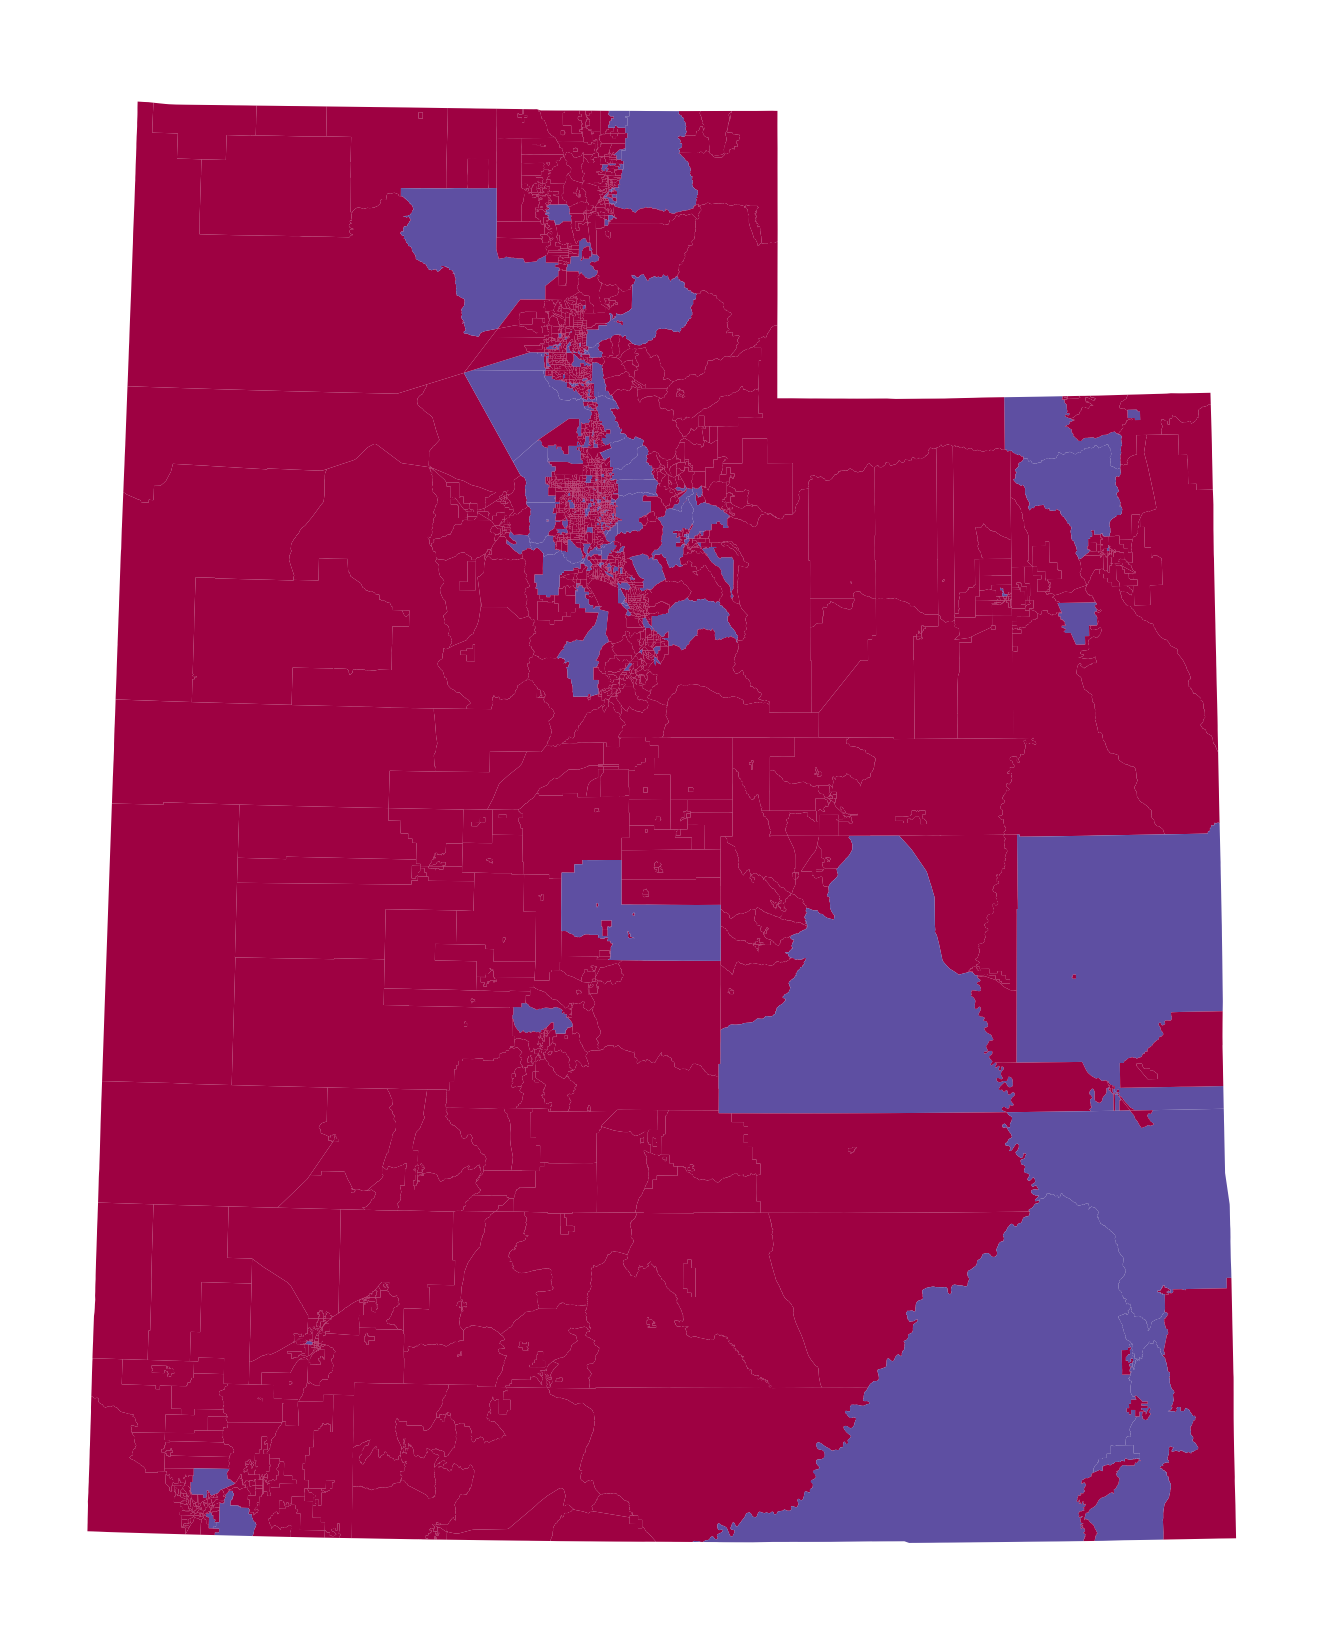

In [15]:
# Plot the results
f = gdf_zp.copy()
f['zero_pop'] = [1 if n in dissolve_zp[zeros_list] else 0 for n in range(len(f))]

# Plot the zero-population nodes
size, dpi =(14,7), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
f.plot(column='zero_pop', ax=ax, cmap='Spectral')
plt.axis("off")

# Legend: Red: Pop > 0, Blue: Pop = 0

# Section 2: Merging Multipolygons

All of the precincts geometries are either a shapely Polygon or a list of shapely Polygons, called a Multipolygon. A Polygon may not be simply connected (i. e. it may have holes) but it will be connected. For Multipolygons we have no such guarantee, and in fact we have reason to suspect that they are disconnected (otherwise they could be cast into a Polygon). To make sure that our Markov chain does not generate disconnected districts, we must ensure that each of the underlying precincts are connected. We can do this by finding all of the precincts which are of type Multipolygon, and then merging them with one of their neighbors. In my code, this choice is made by determining which of the neighbors in the same county and congressional district has the largest shared perimeter with a given district, and then merging that polygon. 

In [83]:
# Choose the graph we operate on 
gdf_zp = precincts
graph_zp = utah
graph, gdf = graph_zp, gdf_zp


In [84]:
# Find the multipolygons
multipolygons = []
for i, poly in enumerate(gdf['geometry']):
    if type(poly) != Polygon:
        multipolygons.append(i)
print(multipolygons)

[17, 19, 40, 90, 107, 109, 112, 118, 128, 130, 131, 137, 139, 140, 141, 142, 146, 150, 152, 156, 161, 211, 229, 235, 238, 239, 242, 248, 249, 262, 281, 315, 317, 318, 319, 321, 322, 323, 330, 331, 341, 343, 363, 395, 444, 515, 525, 532, 543, 556, 557, 569, 599, 602, 604, 607, 610, 613, 615, 624, 629, 630, 634, 636, 638, 646, 661, 670, 688, 719, 722, 749, 844, 957, 981, 1004, 1012, 1013, 1014, 1016, 1021, 1051, 1121, 1131, 1138, 1139, 1145, 1151, 1164, 1165, 1171, 1220, 1224, 1229, 1230, 1242, 1256, 1258, 1280, 1294, 1295, 1307, 1308, 1315, 1319, 1320, 1345, 1353, 1357, 1360, 1361, 1369, 1372, 1375, 1393, 1406, 1414, 1419, 1423, 1430, 1467, 1502, 1510, 1515, 1516, 1518, 1523, 1530, 1531, 1548, 1570, 1571, 1577, 1600, 1604, 1605, 1606, 1607, 1608, 1611, 1612, 1613, 1614, 1615, 1616, 1619, 1623, 1638, 1645, 1646, 1650, 1667, 1688, 1692, 1714, 1715, 1716, 1729, 1731, 1739, 1744, 1749, 1759, 1760, 1763, 1765, 1769, 1770, 1783, 1798, 1808, 1810, 1812, 1816, 1821, 1822, 1824, 1825, 1828, 1830

In [48]:
multipolygons[48]

543

In [50]:
precincts.loc[543] 

index                                                       543
CountyID                                                      3
VistaID                                                 NIB25:I
PrecinctID                                                NIB25
SubPrecinc                                                    I
VersionNbr                                                    5
EffectiveD                                           2012-01-01
AliasName                                                Nibley
Comments                                                   None
RcvdDate                                             2016-05-06
SHAPE_Leng                                              5072.49
SHAPE_Area                                               235649
POP100                                                       28
SEN_DEM                                                0.546575
SEN_REP                                                 3.01096
G_DEM                                   

In [46]:
np.array([counties[graph.nodes[i]['CountyID']] for i in multipolygons])

array(['Kane', 'Tooele', 'Tooele', 'Emery', 'Uintah', 'Uintah', 'Uintah',
       'Uintah', 'Uintah', 'Uintah', 'Uintah', 'Uintah', 'Uintah',
       'Uintah', 'Uintah', 'Uintah', 'Uintah', 'Uintah', 'Uintah',
       'Uintah', 'Garfield', 'Piute', 'Box Elder', 'Box Elder',
       'Box Elder', 'Box Elder', 'Box Elder', 'Box Elder', 'Box Elder',
       'Box Elder', 'Iron', 'Iron', 'Iron', 'Iron', 'Iron', 'Iron',
       'Iron', 'Iron', 'Iron', 'Iron', 'Beaver', 'Beaver', 'Sevier',
       'Sevier', 'Sanpete', 'Cache', 'Cache', 'Cache', 'Cache', 'Cache',
       'Cache', 'Cache', 'Cache', 'Cache', 'Cache', 'Cache', 'Cache',
       'Cache', 'Cache', 'Cache', 'Cache', 'Cache', 'Cache', 'Cache',
       'Duchesne', 'Duchesne', 'Duchesne', 'Duchesne', 'Wasatch',
       'Wasatch', 'Wasatch', 'Washington', 'Washington', 'Davis', 'Davis',
       'Davis', 'Davis', 'Davis', 'Davis', 'Davis', 'Davis', 'Davis',
       'Davis', 'Davis', 'Davis', 'Davis', 'Davis', 'Davis', 'Davis',
       'Davis', 'Davis', 

(206340.0469999997, 696211.4729999999, 4066802.5100000007, 4681513.089999999)

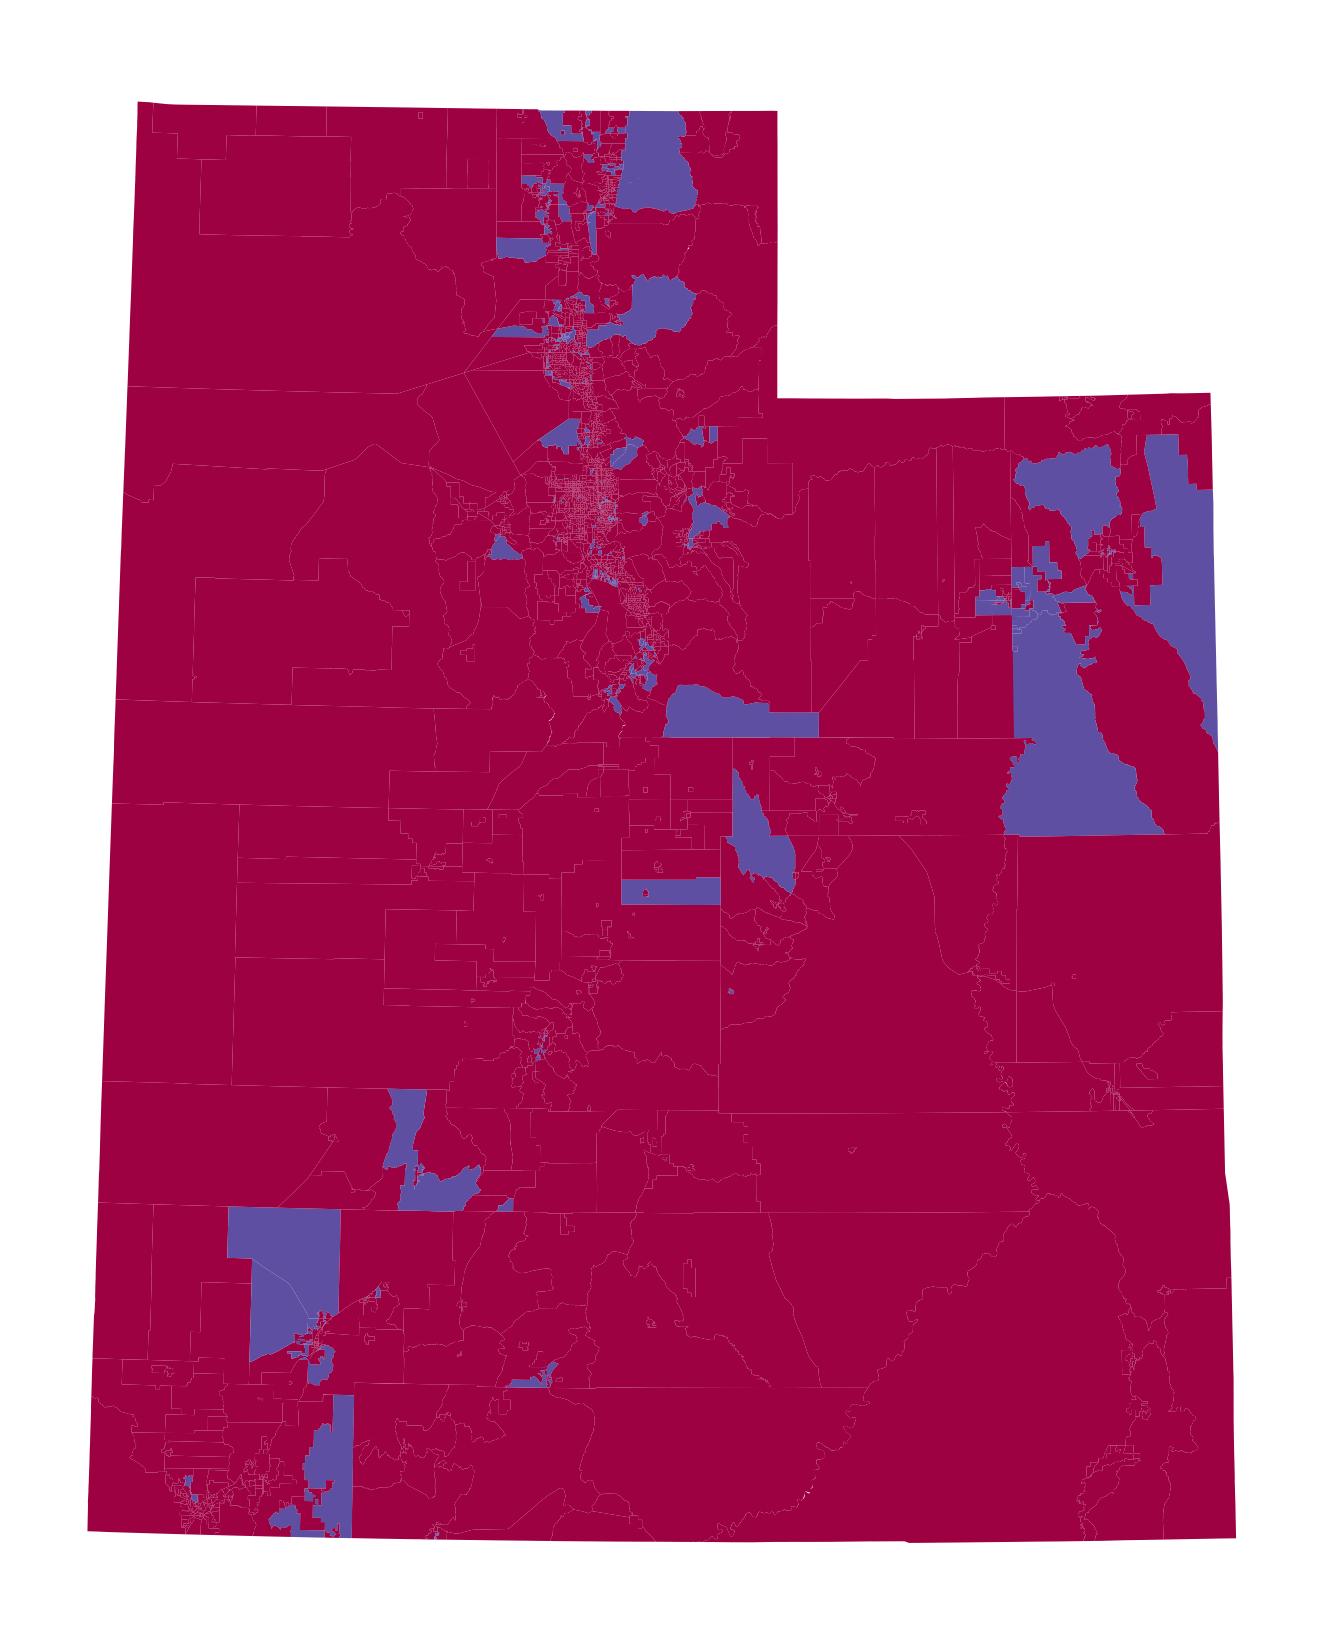

In [49]:
# Mark the multipolygons
mp = np.array([1 if i in multipolygons else 0 for i in range(len(f))])
f = gdf.copy()
f['mp'] = mp

# Plot the multipolygons
size, dpi =(14,7), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
f.plot(column='mp', ax=ax, cmap='Spectral')
plt.axis("off")

# Legend: Red: Polygon, Blue: Multipolygon

The first multipolygon on this list, precinct 17, is in Kane County and looks like this:

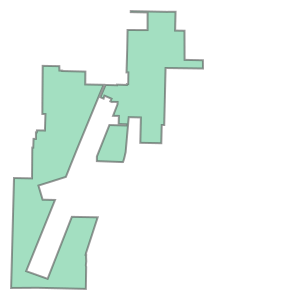

In [50]:
# Example 1
gdf_zp.iloc[17]['geometry'] # original id: 17

It turns out that we can make this precinct into a polygon by merging it with precinct 7:

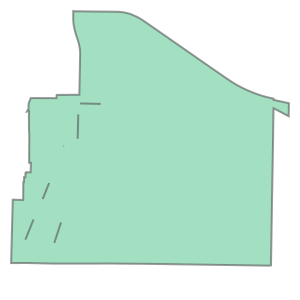

In [51]:
# Example 2 solution
unary_union([gdf.iloc[17]['geometry'], gdf.iloc[7]['geometry']]) # original ids: 7, 17

Uintah county has a lot of these bad precincts. Here I have highlighted all of the bad ones:

In [53]:
uintah = gdf[gdf['CountyID']==24].copy()
slice_to_set = np.zeros(len(uintah))
slice_to_set[np.array(multipolygons[1:14], dtype=np.int32)-104] = 1
uintah['MPs'] = slice_to_set

size, dpi = (3,1), 400
fig, ax = plt.subplots(figsize=size, dpi=dpi)
uintah.plot(column='MPs', ax=ax, lw=0.1)
plt.axis("off")

IndexError: index -85 is out of bounds for axis 0 with size 52

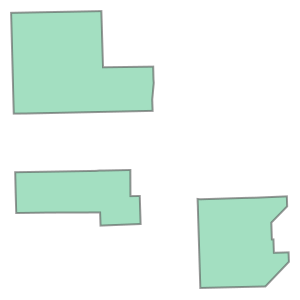

In [54]:
# Example 2
gdf.iloc[107]['geometry'] # original id: 109

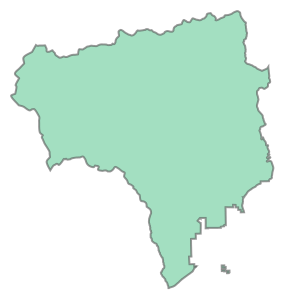

In [55]:
# 118, 142 both make this a Polygon. But 145 has larger shared perimeter
s = unary_union([gdf.iloc[107]['geometry'], gdf.iloc[142]['geometry']])
s
# Original ids: 109, 120, 145

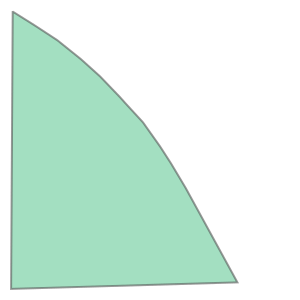

In [56]:
# Example 3
gdf.iloc[105]['geometry'] # original id: 107

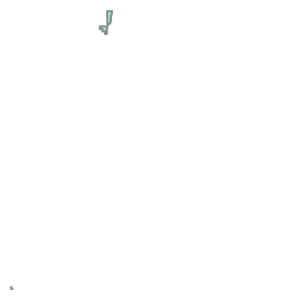

In [57]:
# 141, 133 are possibilities (133 wins)
s = unary_union([gdf.iloc[105]['geometry'], gdf.iloc[133]['geometry']])
s
# Original ids: 107, 136, 144

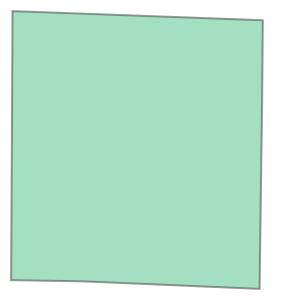

In [58]:
# Example 4: what a weird precinct
gdf.iloc[526]['geometry'] # original precinct id: 543

In [71]:
precincts.iloc[592]

index                                                       592
CountyID                                                      3
VistaID                                                 NIB01:I
PrecinctID                                                NIB01
SubPrecinc                                                    I
VersionNbr                                                    5
EffectiveD                                           2012-01-01
AliasName                                                Nibley
Comments                                                   None
RcvdDate                                             2016-05-06
SHAPE_Leng                                                10872
SHAPE_Area                                           2.9247e+06
POP100                                                     1919
SEN_DEM                                                  39.682
SEN_REP                                                 210.684
G_DEM                                   

In [72]:
precincts.iloc[543]

index                                                       543
CountyID                                                      3
VistaID                                                 NIB25:I
PrecinctID                                                NIB25
SubPrecinc                                                    I
VersionNbr                                                    5
EffectiveD                                           2012-01-01
AliasName                                                Nibley
Comments                                                   None
RcvdDate                                             2016-05-06
SHAPE_Leng                                              5072.49
SHAPE_Area                                               235649
POP100                                                       28
SEN_DEM                                                0.546575
SEN_REP                                                 3.01096
G_DEM                                   

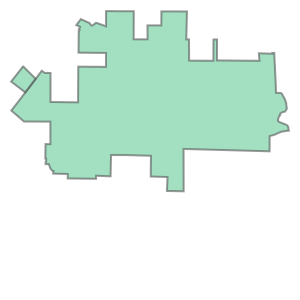

In [70]:
# Here we need to use two neighbors to make this a polygon: This one needs 570 and 568 to make it a polygon
s = unary_union([gdf.iloc[543]['geometry'], gdf.iloc[590]['geometry'], gdf.iloc[592]['geometry']])
s
# Original ids: 543, 590, 592

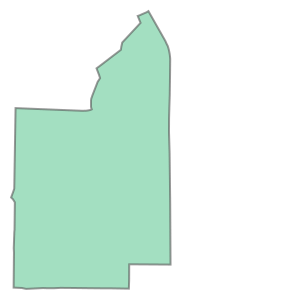

In [59]:
# Example 5: Wow
gdf.iloc[1582]['geometry'] # Original precinct id: 1729

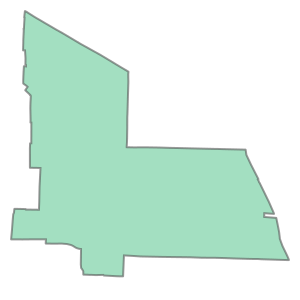

In [30]:
# 1632 and 1668 are needed
s = unary_union([gdf.iloc[1582]['geometry'], gdf.iloc[1455]['geometry'], gdf.iloc[1490]['geometry']])
s

As we can see above, in many cases, we simply have to search for one adjacent precinct to merge to make a precinct into a polygon. However, in some cases, we need multiple adjacent polygons to do the job. This is further complicated by the fact that some multipolygons are adjacent to other multipolygons, which might resolve some islands when merged but leave others beyond the adjacency reach of the first multipolygon. This is all dealt with in my code merge_multipolygons.

In [85]:
neighbors_in_county = [n for n in graph[543].keys()
                               if graph.nodes[n]['CountyID'] == graph.nodes[543]['CountyID']
                               and graph.nodes[n]['US_Distric'] == graph.nodes[543]['US_Distric']]

In [86]:
neighbors_in_county

[540, 590, 593]

In [58]:
single_mp = True # store it in this flag
for n in neighbors_in_county:
    if n in multipolygons:
        single_mp = False
        break
single_mp

True

In [68]:
possibilities = []
comb_number = 2
for comb in itertools.combinations(neighbors_in_county, comb_number):
    print(comb)

(540, 590)
(540, 593)
(590, 593)


In [65]:
list(gdf.iloc[543]['geometry'])

In [63]:
while len(possibilities) == 0:

                # Iterate through all combinations of neighboring precincts
                # At the beginning, just try combinations of length 1
    for comb in itertools.combinations(neighbors_in_county, comb_number):

                    # Merge adjacent polygon(s)
        s = unary_union(list(gdf.iloc[543]['geometry']) + [gdf.iloc[n]['geometry'] for n in comb])
        s

KeyboardInterrupt: 

In [51]:
# time to run: approx 1 min
merge_mp = merge_multipolygons(graph, gdf)
dissolve_mp = merge_mp.get_dissolve()

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 

KeyboardInterrupt: 

In [ ]:
# Get the multipolygons along with the nodes they will be merged with
f = gdf.copy()
s = set([subpart for part in merge_mp.merges for subpart in part])
mps_and_neighbors = np.array([1 if (n in s) else 0 for n in range(len(f)) ])

f['mp'] = 0.5*(mp + mps_and_neighbors)

# Plot the zero-population nodes
size, dpi = (14,7), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
f.plot(column='mp', ax=ax, cmap='Spectral')
plt.axis("off")

# Legend: Red: Polygon, Blue: Multipolygon, Yellow: Neighboring precinct selected to be merged 

In [ ]:
merge_zp_mp = merge_zp * merge_mp
dissolve_zp_mp = merge_zp_mp.get_dissolve()

In [ ]:
# Perform the merge
gdf_zp_mp = perform_dissolve_gdf(gdf_zp, dissolve_mp)
graph_zp_mp = perform_dissolve_graph(graph_zp, dissolve_mp)

In [35]:
# We decreased by
len(graph_zp) - len(graph_zp_mp)

188

In [ ]:
# Plot the results

f = gdf_zp_mp.copy()
f['mp'] = np.array([1 if i in dissolve_mp[multipolygons] else 0 for i in range(len(f))])

# Plot the multipolygons
size, dpi =(14,7), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
f.plot(column='mp', ax=ax, cmap='Spectral')
plt.axis("off")

# Legend: Red: Polygon, Blue: Merged Multipolygon

# Section 3: One Neighbor Precincts and Separating Precincts

One essential motivation for merging precincts is to streamline the process of using Monte Carlo Markov Chain models via the flip proposal. The flip proposal is the transition between states in our Markov chain. It selects a precinct on one of the cut edges of the graph, and then changes its district assignment to the adjacent district. This transition forms a reversible Markov Chain. By simulating thousands of these flips, we hope to explore the sample space of possible districting plans. However, the flip proposal has some limitations. In particular, if precint A is contained inside precinct B (and thus has no other neighboring precincts) and precinct B is selected to be flipped, when the new districting assignment is generated, B's old district will be left discontiguous and thus invalid, because A will be a disconnected precinct in the old district. The algorithm will reject the new proposed plan due to its invalidity. Therefore, the precinct B (and precinct A) can never be flipped into a different district, and the Markov chain will not explore the whole sample space, and may be confined to a particular region of the sample space. Of course, the solution is that A and B can be flipped if they are flipped together. The simplest way to proceed is to use the normal flipping algorithm, but after having merged precincts A and B.

In [37]:
# Choose the graph we operate on 
graph, gdf = graph_zp_mp, gdf_zp_mp

In [38]:
# Find all the one-neighbor precincts
lengths, ids, neighbor_ids, containers, merge1 = get_one_neighbor(graph)

Node:  34 , Neighbor:  51 , County:  Tooele
Node:  35 , Neighbor:  72 , County:  Tooele
Node:  84 , Neighbor:  85 , County:  Emery
Node:  86 , Neighbor:  87 , County:  Emery
Node:  88 , Neighbor:  89 , County:  Emery
Node:  100 , Neighbor:  101 , County:  Emery
Node:  149 , Neighbor:  140 , County:  Garfield
Node:  150 , Neighbor:  146 , County:  Garfield
Node:  152 , Neighbor:  147 , County:  Garfield
Node:  153 , Neighbor:  144 , County:  Garfield
Node:  154 , Neighbor:  145 , County:  Garfield
Node:  181 , Neighbor:  176 , County:  Wayne
Node:  182 , Neighbor:  179 , County:  Wayne
Node:  183 , Neighbor:  175 , County:  Wayne
Node:  184 , Neighbor:  178 , County:  Wayne
Node:  185 , Neighbor:  177 , County:  Wayne
Node:  197 , Neighbor:  198 , County:  Box Elder
Node:  242 , Neighbor:  231 , County:  Box Elder
Node:  243 , Neighbor:  201 , County:  Box Elder
Node:  244 , Neighbor:  200 , County:  Box Elder
Node:  245 , Neighbor:  199 , County:  Box Elder
Node:  291 , Neighbor:  258 

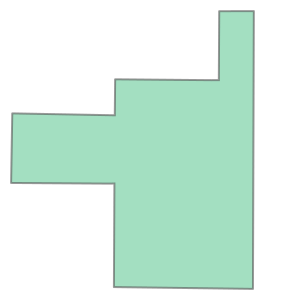

In [39]:
# Some examples: original ids 35 / 52, 36 / 74
gdf.iloc[35]['geometry'] # original id 36

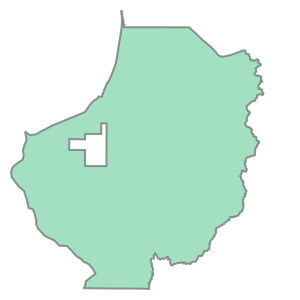

In [40]:
gdf.iloc[72]['geometry'] # original id 74

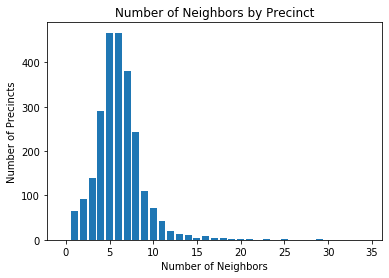

In [41]:
plt.bar(np.arange(35), lengths)
plt.title("Number of Neighbors by Precinct")
plt.xlabel("Number of Neighbors")
plt.ylabel("Number of Precincts")
plt.show()

(206337.84766411144, 696213.6725121047, 4066800.310246099, 4681515.28842151)

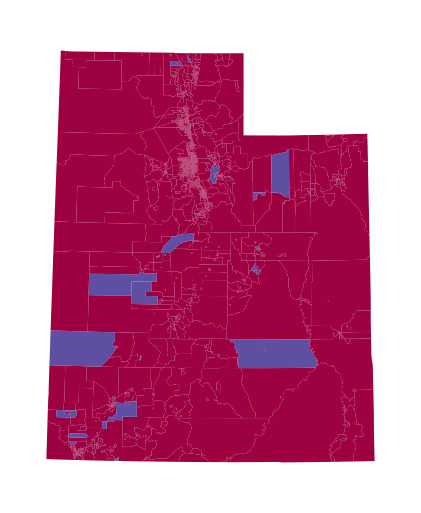

In [42]:
# Mark the one-neighbor nodes
f = gdf.copy()
f["one neighbor"] = np.array([1 if i in ids + neighbor_ids else 0 for i in range(len(f))])

# Plot the one neighbor precincts with their one neighbor
size, dpi =(3,2), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
f.plot(column='one neighbor', ax=ax, cmap='Spectral')
plt.axis("off")

# Legend: Red: Normal Precinct, Blue: Precint with only one neighbor, or containing such a precinct

But there are some precincts that contain more than one adjacent precinct. How do we find these?

In [43]:
dissolve_zp_mp[450]

404

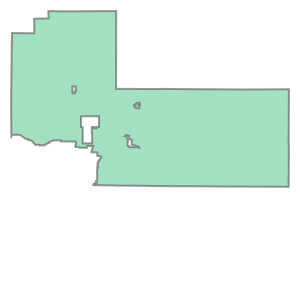

In [44]:
# For example, this precinct, which contains 5 other precincts, 
# two of which are adjacent, so they are not "one neighbor precincts"
gdf.iloc[404]['geometry'] # original id: 450

These could be termed "separating precincts" because if we remove them from the adjacency graph, the resulting graph is disconnected. This is the foundation for the get_separators algorithm which finds all of these precincts

In [45]:
# Find all the separating precincts, approx 5 min
ids2, neighbor_ids2, separators, merge_sp = get_separators(graph)

Total: 80


In [46]:
# Make sure it is performing correctly

# This should print nothing
for node in neighbor_ids:
    if node not in neighbor_ids2:
        print(node)
        
print('')

# This could print some precincts (the additional ones, like 404)
for node in neighbor_ids2:
    if node not in neighbor_ids:
        print(node)


294
399
439
650
1866


In [47]:
merge1 in merge_sp

True

(206337.84766411144, 696213.6725121047, 4066800.310246099, 4681515.28842151)

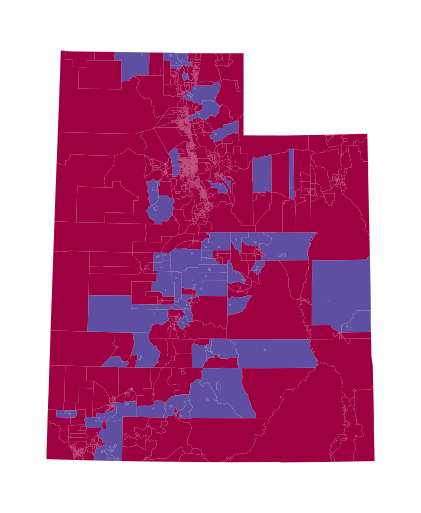

In [48]:
# Mark the one-neighbor nodes
f = gdf.copy()
f["one neighbor"] = np.array([1 if (i in ids2 or i in neighbor_ids2) else 0 for i in range(len(f))])

# Plot the one neighbor precincts with their one neighbor
size, dpi =(3,2), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
f.plot(column='one neighbor', ax=ax, cmap='Spectral')
plt.axis("off")

# Legend: Red: Normal Precinct, Blue: Separating precinct, or precinct contained in it

# plt.savefig("isolated_precincts2.png", dpi=dpi, bbox_inches="tight")

# Look at Sanpete County!

In [49]:
dissolve_sp = merge_sp.get_dissolve()

# Merge so that the new merged precincts are flippable
gdf_zp_mp_sp = perform_dissolve_gdf(gdf_zp_mp, dissolve_sp)
graph_zp_mp_sp = perform_dissolve_graph(graph_zp_mp, dissolve_sp)

C:\Users\Jacob\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [50]:
merge_zp_mp_sp = merge_zp_mp * merge_sp
dissolve_zp_mp_sp = merge_zp_mp_sp.get_dissolve()

(206337.84766411144, 696213.6725121047, 4066800.310246099, 4681515.28842151)

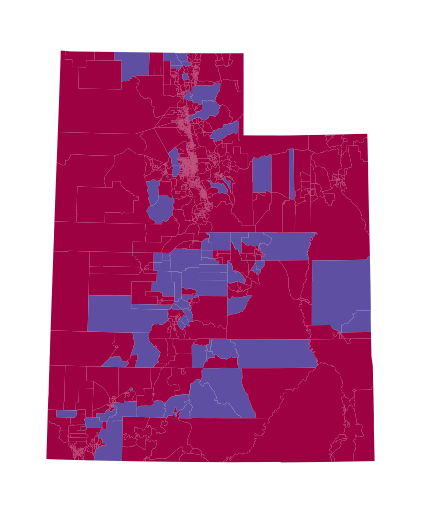

In [51]:
# Mark the merged precincts
f = gdf_zp_mp_sp.copy()
f["one neighbor"] = np.array([1 if (n in dissolve_sp[ids2] or n in dissolve_sp[neighbor_ids2]) else 0 for n in range(len(f))])

# Plot the one neighbor precincts with their one neighbor
size, dpi =(3,2), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
f.plot(column='one neighbor', ax=ax, cmap='Spectral')
plt.axis("off")

# Legend: Red: Normal Precinct, Blue: Separating precinct, or precinct contained in it (Merged)
# plt.savefig("isolated_precincts_merged1.png", dpi=dpi, bbox_inches="tight")

In [52]:
# We decreased by
len(graph_zp_mp) - len(graph_zp_mp_sp)

80

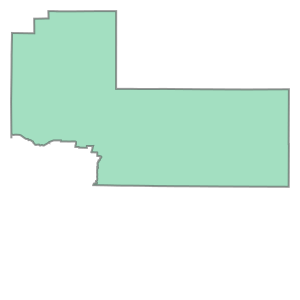

In [53]:
# Take a look at this precinct, the same one I showed before. All of its holes are patched up
gdf_zp_mp_sp.iloc[345]['geometry'] # original id: 450

Now we can check to see that these new geometries and adjacencies do, in fact, satisfy all the properties we claim:

In [54]:
# No zero population nodes
all(graph_zp_mp_sp.nodes[n]['POP100'] > 0 for n in graph_zp_mp_sp.nodes)

True

In [55]:
# No multipolygons
all(type(poly) == Polygon for poly in gdf_zp_mp_sp['geometry'])

True

In [56]:
# No separating precincts (approx 5 min to run)
separate = []
for node in graph_zp_mp_sp:
    copy = graph_zp_mp_sp.copy()
    copy.remove_node(node)
    separate.append(nx.is_connected(copy))
all(separate)

True

In [63]:
# Check that the total population stayed the same
sum(graph_zp_mp_sp.nodes[n]['POP100'] for n in graph_zp_mp_sp.nodes) == sum(utah.nodes[n]['POP100'] for n in utah.nodes)

True

In [64]:
len(graph_zp_mp_sp)

2365

Now we can package these files up:

In [93]:
# gdf_zp_mp_sp.to_file("gdf_zp_mp_sp.shp")

In [65]:
# pickle.dump(graph_zp_mp_sp, open("graph_zp_mp_sp.pkl", 'wb'))

# Section 4: Check to see which cut edges are "unflippable"

In [60]:
my_updaters = {"population": updaters.Tally("POP100", alias="population"),
               "d": updaters.Tally("DEM", alias="d"),
               "r": updaters.Tally("REP", alias="r"),
               "polsby_popper": polsby_popper,
               "split_counties": SplitCounties()
              }

elections = [ Election("SEN10", {"Dem": "DEM", "Rep": "REP"})]

election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

initial_partition = GeographicPartition(graph_zp_mp_sp, "US_Distric", my_updaters)
problematic_edges = []
for edge in initial_partition['cut_edges']:
    a, b = edge[0], edge[1]
    f1 = constraints.single_flip_contiguous(initial_partition.flip({a: initial_partition.assignment[b]}))
    f2 = constraints.single_flip_contiguous(initial_partition.flip({b: initial_partition.assignment[a]}))
    
    if not (f1 and f2):
        problematic_edges.append(edge)

In [61]:
problematic_edges

[(2130, 2227),
 (1050, 1073),
 (555, 1449),
 (527, 1055),
 (1752, 2341),
 (1829, 2227),
 (1858, 1982),
 (1602, 2359),
 (357, 1055),
 (1788, 2359),
 (1041, 1170),
 (86, 345),
 (88, 345),
 (2340, 2341),
 (1651, 1964),
 (2012, 2359),
 (1595, 2227),
 (1858, 1878),
 (572, 1492),
 (514, 1055),
 (1788, 1858),
 (1073, 1108),
 (1170, 1193),
 (166, 1428),
 (145, 973),
 (2341, 2363),
 (1651, 2359),
 (147, 1073),
 (1964, 2056),
 (2056, 2359),
 (95, 345),
 (1170, 1177),
 (555, 1474),
 (1878, 1964),
 (144, 1073),
 (1731, 1964),
 (148, 345),
 (145, 162),
 (982, 1170),
 (1073, 1139),
 (1961, 2359)]

# Look at the results:

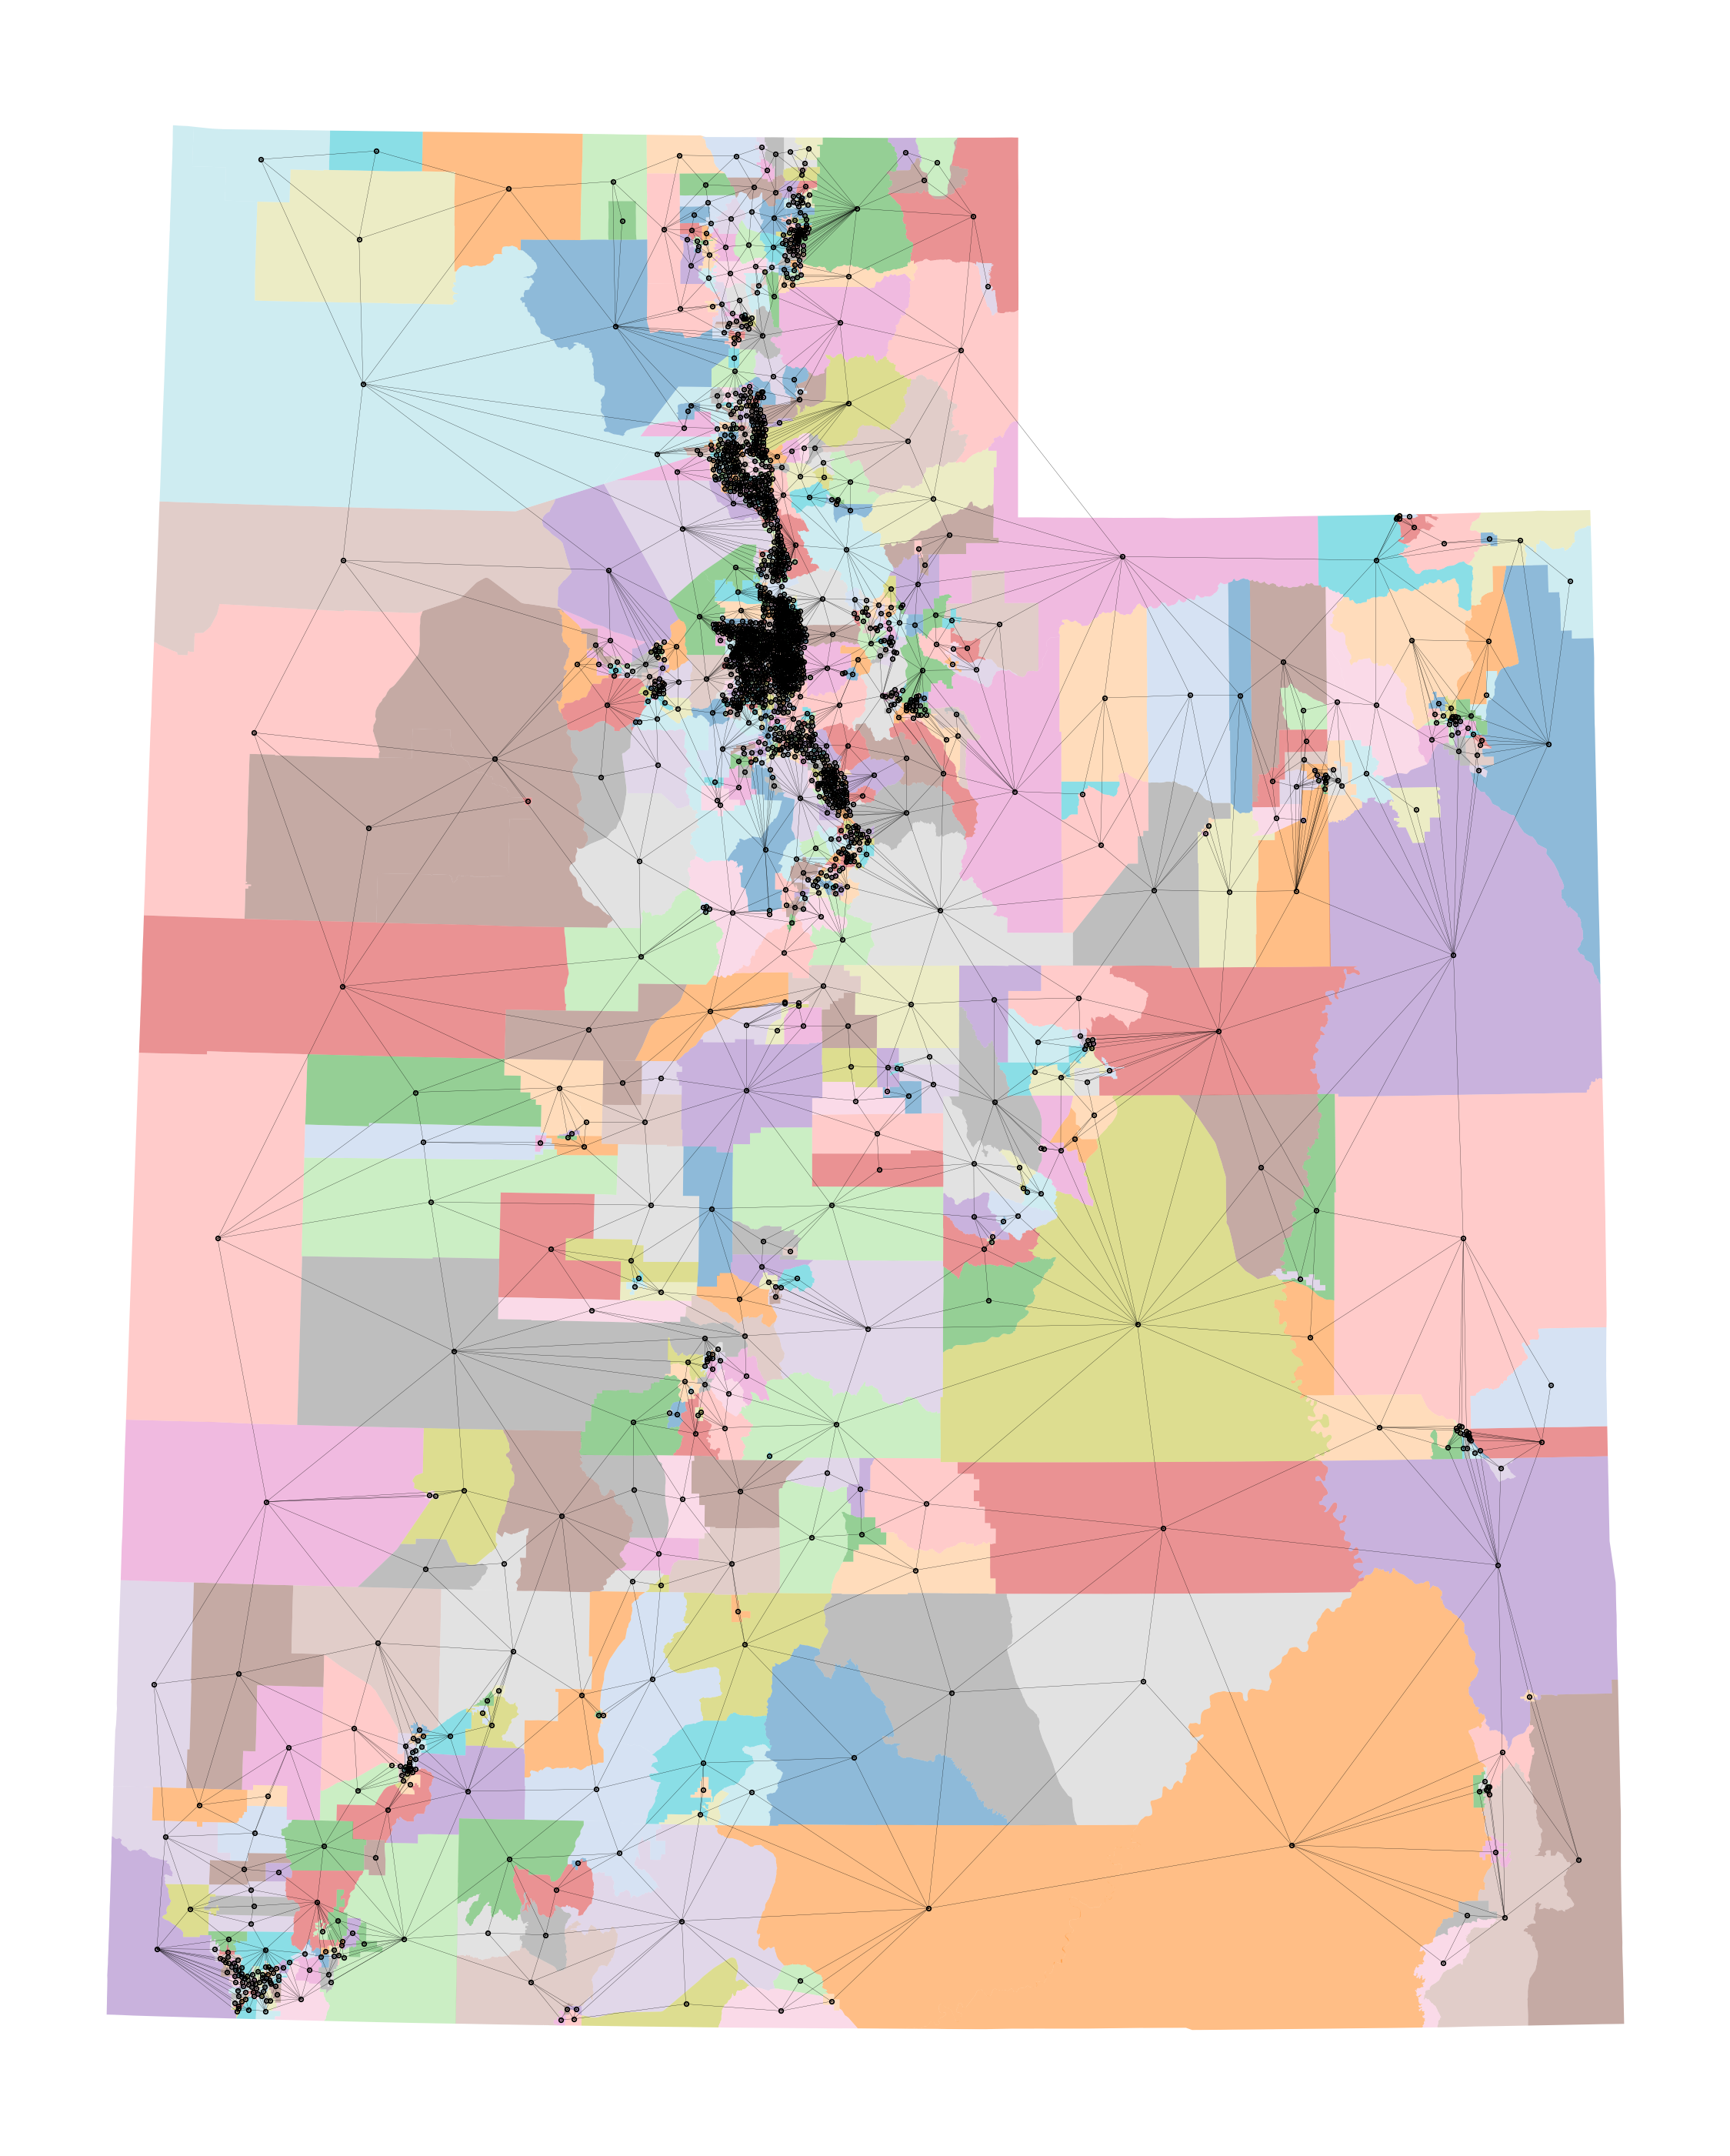

In [62]:
# Plot with isolated precincts removed
plot_graph(gdf_zp_mp_sp, graph_zp_mp_sp, dpi=400, size=7, save=False, savetitle='graph_after_merging1.png')